In [2]:
import logging
import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pyarrow.parquet as pa

import tensorflow as tf
import tensorflow.keras as k
import ShapeChecker
import einops
import tensorflow_text
import tensorflow_datasets as tfds
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

In [3]:
tf.get_logger().setLevel('ERROR')

In [4]:
table = pa.read_table('./data/to_swedish.parquet')
df = table.to_pandas()
df = df.iloc[:350000,:]
len(df)

350000

In [5]:
table_val = pa.read_table('./data/to_swedish_val.parquet')
df_val = table_val.to_pandas()
df_val.head()

,translation
0,"{'en': 'Good, Zara's right behind you.', 'sv':..."
1,"{'en': 'That doesn't make any sense, does it, ..."
2,{'en': 'The people of Belgium were not to be g...
3,{'en': 'The charter must therefore ensure that...
4,{'en': 'The warden has granted you open visits...


In [6]:
en_train_ds = np.array([row['en'] for row in df['translation']])
sv_train_ds = np.array([row['sv'] for row in df['translation']])

In [7]:
en_val_ds = np.array([row['en'] for row in df_val['translation']])
sv_val_ds = np.array([row['sv'] for row in df_val['translation']])

In [8]:
BUFFER_SIZE = 8000
BATCH_SIZE = 64

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((sv_train_ds, en_train_ds))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((sv_val_ds, en_val_ds))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [9]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'KAPITEL I' b'V\xc3\xa4stbengalens incitamentsystem.'
 b'Vad g\xc3\xa4ller v\xc3\xa5r information har ingen WTO-medlem i dag beg\xc3\xa4rt n\xc3\xa5gon diskussion om f\xc3\xb6rkortningen av patentens l\xc3\xa4ngd.'
 b'- \xc3\x84r vi \xc3\xb6verens, eller?'
 b'- Vi d\xc3\xb6dar honom... - Nej!'], shape=(5,), dtype=string)

tf.Tensor(
[b'CHAPTER I' b'West Bengal Incentives Scheme.'
 b'According to the information available to us, none of the WTO members have yet requested a debate on reducing the term of patents.'
 b'We got a deal or not?' b'- We will kill this man.'], shape=(5,), dtype=string)


In [10]:
example_text = tf.constant('Hello Tom, How are you today?')

print(example_text.numpy())
print(tensorflow_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Hello Tom, How are you today?'
b'Hello Tom, How are you today?'


In [11]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tensorflow_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [12]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Hello Tom, How are you today?
[START] hello tom ,  how are you today ? [END]


In [17]:
max_vocab_size = 10000

swedish_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [18]:
max_vocab_size = 10000

english_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [19]:
swedish_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
swedish_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', ',', 'det', 'att', 'jag', 'ar']

In [20]:
english_text_processor.adapt(train_raw.map(lambda context, target: target))

# Here are the first 10 words from the vocabulary:
english_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', ',', 'the', 'to', 'of', 'you']

In [21]:
example_tokens = english_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 1, 11, 3], [2, 1, 1, 4, 3],
 [2, 1, 1, 1, 188, 1, 1, 1, 11, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 3]]>

In [22]:
context_vocab = np.array(english_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] [UNK] i [END]'

Text(0.5, 1.0, 'Mask')

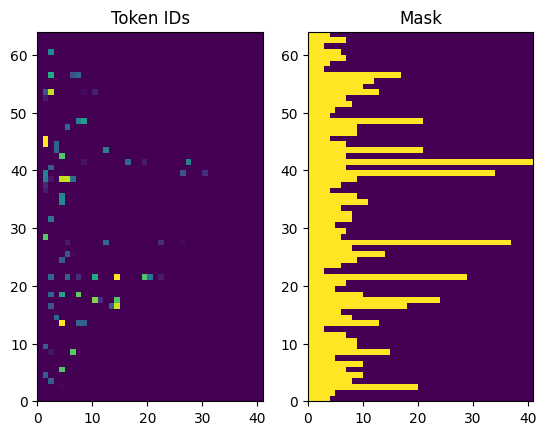

In [23]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [52]:
def process_text(context, target):
  context = swedish_text_processor(context).to_tensor()
  target = english_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [53]:

for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[   2   17   22 1522    3    0    0    0    0    0]

[   2    8 1876    0    0    0    0    0    0    0]
[   8 1876    3    0    0    0    0    0    0    0]


In [54]:
UNITS = 256

In [56]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    # shape_checker = ShapeChecker()
    # shape_checker.shapecheck(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    # shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    # shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [57]:
# Encode the input sequence.
encoder = Encoder(swedish_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 28)
Encoder output, shape (batch, s, units): (64, 28, 256)


In [58]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    # shape_checker = ShapeChecker()

    # shape_checker(x, 'batch t units')
    # shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    # shape_checker(x, 'batch t units')
    # shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    # shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [59]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(swedish_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 28, 256)
Target sequence, shape (batch, t, units): (64, 33, 256)
Attention result, shape (batch, t, units): (64, 33, 256)
Attention weights, shape (batch, t, s):    (64, 33, 28)


In [60]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.       , 1.0000001, 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       , 1.       ,
       1.       , 1.       , 1.       ], dtype=float32)

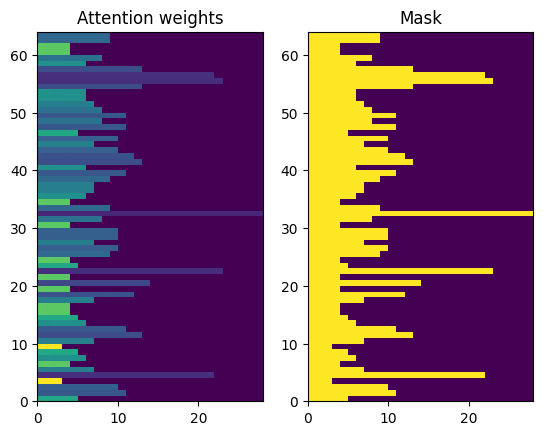

In [61]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [62]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [63]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  # shape_checker = ShapeChecker()
  # shape_checker(x, 'batch t')
  # shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  # shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  # shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  # shape_checker(x, 'batch t units')
  # shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  # shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [64]:
decoder = Decoder(english_text_processor, UNITS)

In [65]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 28, 256)
input target tokens shape: (batch, t) (64, 33)
logits shape shape: (batch, target_vocabulary_size) (64, 33, 10000)


In [66]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [67]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [68]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [69]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'employment roy packed balanced whispering rage petty daniel creation questioning',
       b'skill phone villages unhappy remarkable footage drunk competent wet hung',
       b'vital deliberate explaining plot decreased bombing specifies at advantage escape'],
      dtype=object)

In [71]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [72]:
model = Translator(UNITS,  swedish_text_processor, english_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 28)
Target tokens, shape: (batch, t) (64, 33)
logits, shape: (batch, t, target_vocabulary_size) (64, 33, 10000)


In [74]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [75]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [76]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [77]:
vocab_size = 1.0 * swedish_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 9.2103405, 'expected_acc': 0.0001}

In [78]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 14s 372ms/step - loss: 9.2166 - masked_acc: 0.0000e+00 - masked_loss: 9.2166


{'loss': 9.216612815856934,
 'masked_acc': 0.0,
 'masked_loss': 9.216612815856934}

In [95]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 200,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
200/200 [==============================] - 205s 1s/step - loss: 2.3504 - masked_acc: 0.5558 - masked_loss: 2.3504 - val_loss: 2.8897 - val_masked_acc: 0.4851 - val_masked_loss: 2.8897
Epoch 2/100
200/200 [==============================] - 226s 1s/step - loss: 2.4382 - masked_acc: 0.5435 - masked_loss: 2.4382 - val_loss: 2.8500 - val_masked_acc: 0.4892 - val_masked_loss: 2.8500
Epoch 3/100
200/200 [==============================] - 229s 1s/step - loss: 2.4487 - masked_acc: 0.5426 - masked_loss: 2.4487 - val_loss: 2.8570 - val_masked_acc: 0.4874 - val_masked_loss: 2.8570
Epoch 4/100
200/200 [==============================] - 237s 1s/step - loss: 2.4124 - masked_acc: 0.5446 - masked_loss: 2.4124 - val_loss: 2.8697 - val_masked_acc: 0.4872 - val_masked_loss: 2.8697
Epoch 5/100
200/200 [==============================] - 267s 1s/step - loss: 2.4112 - masked_acc: 0.5472 - masked_loss: 2.4112 - val_loss: 2.8732 - val_masked_acc: 0.4847 - val_masked_loss: 2.8732
Epoch 6/100
200/200 

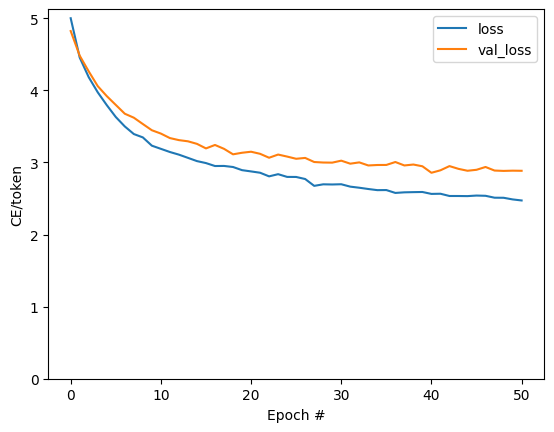

In [81]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

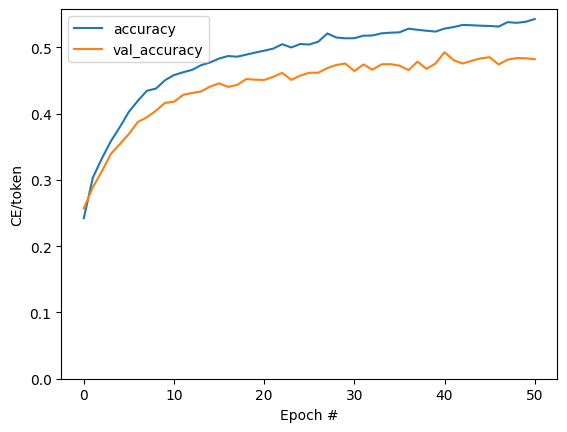

In [82]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [98]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [99]:
result = model.translate(['Är du fortfarande hemma?']) # ¿Todavía está en casa?
result[0].numpy().decode()

'are you still at home ? '

In [101]:
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_43228\2375050876.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_43228\2375050876.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


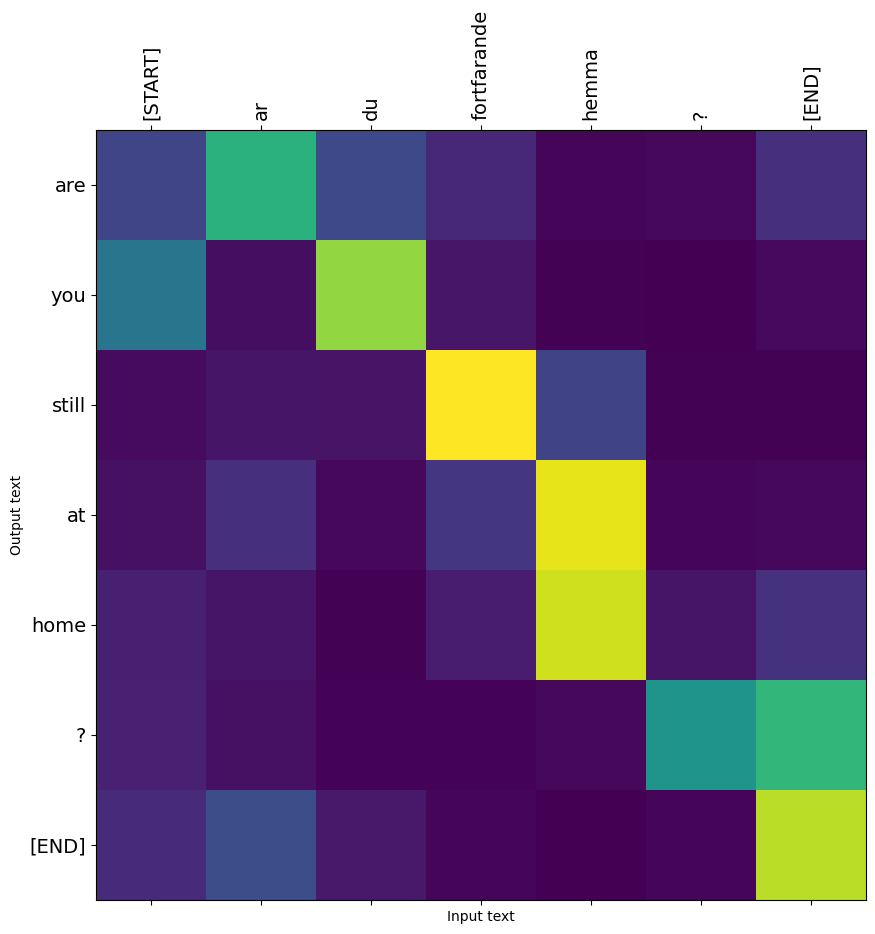

In [102]:
model.plot_attention('Är du fortfarande hemma?') # ¿Todavía está en casa?

C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_43228\2375050876.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_43228\2375050876.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


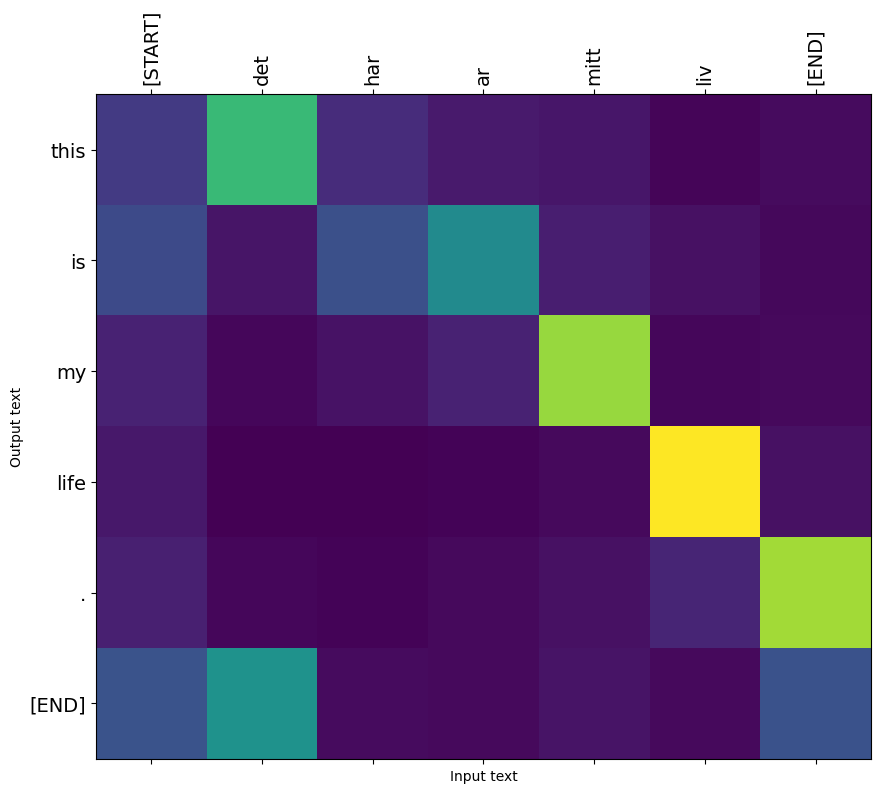

In [103]:
model.plot_attention('Det här är mitt liv') # Esta es mi vida.

C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_43228\2375050876.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_43228\2375050876.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


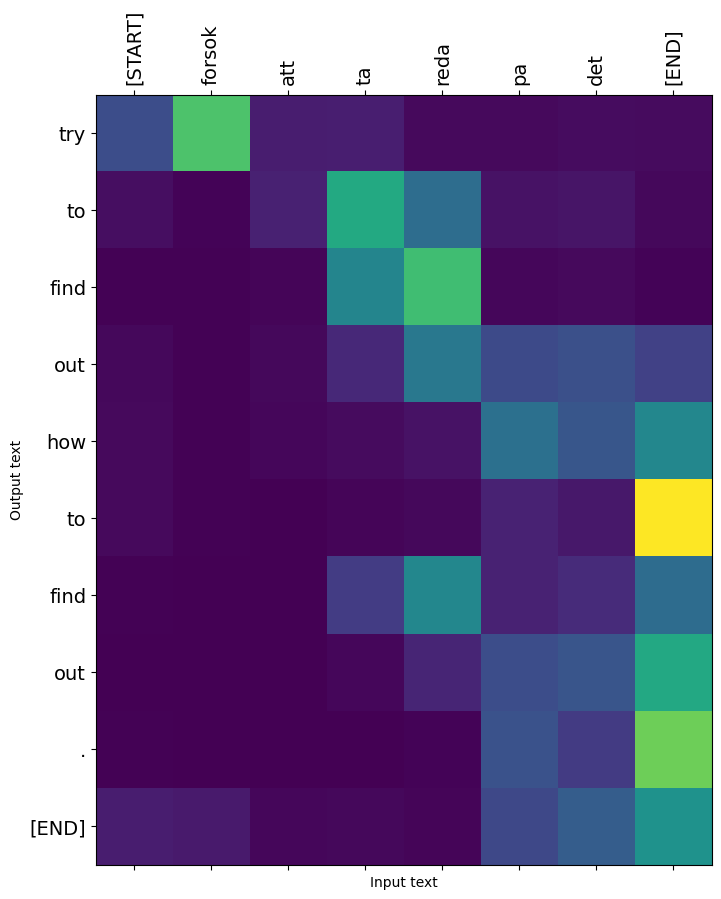

In [104]:
model.plot_attention('Försök att ta reda på det') # Tratar de descubrir.

In [105]:
long_text = """Vad olyckan beror på är oklart, men enligt räddningstjänsten är det mycket halt på vägen. Händelsen har skett i norrgående riktning, men båda riktningarna är avstängda. Detta gör att trafiken leds om under morgonen via gamla E6:an. Det kommer vara påverkan i många timmar framöver, säger Daniel Svensmark."""

C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_43228\2375050876.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\SamuelMcmurray\AppData\Local\Temp\ipykernel_43228\2375050876.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


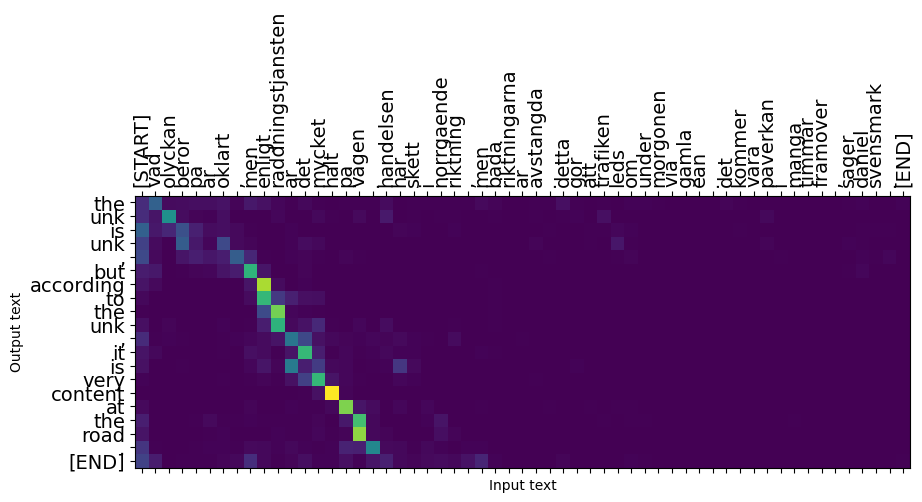

In [106]:
model.plot_attention(long_text)

In [109]:
inputs = [
    "Är du fortfarande hemma?", # 'Hace mucho frio aqui.'
    "Det här är mitt liv", # 'Esta es mi vida.'
    "Försök att ta reda på det" # 'Su cuarto es un desastre.'
]

In [ ]:
for t in inputs:
  print(model.translate([t])[0].numpy().decode())

print()

In [110]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [111]:
export = Export(model)

In [115]:
_ = export.translate(tf.constant(inputs))

In [116]:
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

are you still at home ?                                            
this is my life .                                             
try to find out how to find out .                                         



In [113]:
tf.saved_model.save(export, 'models/sv_en_translation',
                    signatures={'serving_default': export.translate})

In [114]:
reloaded = tf.saved_model.load('models/sv_en_translation')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [117]:
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

are you still at home ?                                            
this is my life .                                             
try to find out how to find out .                                         



In [118]:
converter = tf.lite.TFLiteConverter.from_keras_model(export)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
converter.experimental_enable_resource_variables = True 
tflite_model = converter.convert()
# Save the model.
with open('tflite_models/sv_en_translation.tflite', 'wb') as f:
  f.write(tflite_model)

In [119]:
interpreter = tf.lite.Interpreter(model_path='tflite_models/sv_en_translation.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

interpreter.set_tensor(input_details[0]['index'], np.array([inputs[0]]))

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[b'are you still at home ?                                            ']
